In [ ]:
# Colab cell 1
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Colab cell 2 (shell)
# install required libs in Colab
!pip install -q sentence-transformers faiss-cpu transformers datasets accelerate evaluate \
              "torch>=2.0" datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
# Colab cell 3
import os
DRIVE_ROOT = "/content/drive/MyDrive/Amazon-Analysis"   # change if you used different path
DATA_DIR = os.path.join(DRIVE_ROOT, "data")
MODEL_DIR = os.path.join(DRIVE_ROOT, "backend", "models")
os.makedirs(MODEL_DIR, exist_ok=True)
print("Data dir:", DATA_DIR)
print("Model dir:", MODEL_DIR)


Data dir: /content/drive/MyDrive/Amazon-Analysis/data
Model dir: /content/drive/MyDrive/Amazon-Analysis/backend/models


In [ ]:
# Colab cell 4
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
import pickle
from tqdm import tqdm

products = pd.read_csv(os.path.join(DATA_DIR, "products.csv"))
print("Products:", len(products))

model_name = "all-MiniLM-L6-v2"   # fast and good
model = SentenceTransformer(model_name)

texts = (products['title'].fillna("") + " " + products.get('description', "").fillna("")).tolist()

batch_size = 256   # adjust (bigger = faster until GPU mem limit)
embs = []
for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    emb = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True)
    embs.append(emb)
emb_arr = np.vstack(embs)

# normalize (for cosine similarity with Faiss inner product)
import faiss
faiss.normalize_L2(emb_arr)

# save to Drive
np.save(os.path.join(MODEL_DIR, "product_embeddings.npy"), emb_arr)
products.to_pickle(os.path.join(MODEL_DIR, "products.pkl"))
print("Saved embeddings & products")


Products: 827727


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 3234/3234 [19:59<00:00,  2.70it/s]


Saved embeddings & products


In [ ]:
# Colab cell 5
import faiss
d = emb_arr.shape[1]
index = faiss.IndexFlatIP(d)   # inner product on normalized vectors = cosine
index.add(emb_arr)
faiss.write_index(index, os.path.join(MODEL_DIR, "faiss_index.idx"))
print("Saved Faiss index at", os.path.join(MODEL_DIR, "faiss_index.idx"))


Saved Faiss index at /content/drive/MyDrive/Amazon-Analysis/backend/models/faiss_index.idx


In [ ]:
# 2. Install kagglehub
!pip install -q kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# 3. Choose dataset + file to download
dataset = "magdawjcicka/amazon-reviews-2018-electronics"

# ⚠️ Check the dataset page for exact file names
file_path = "electronics_small.csv"   # or "Electronics_5.json.gz"

# 4. Load into pandas
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset,
    file_path,
    pandas_kwargs={"low_memory": False}
)

# 5. Save into Google Drive folder
save_path = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"
df.to_csv(save_path, index=False)

print(f"✅ File saved to: {save_path}")


# 5. Preview
print("Shape:", df.shape)
print("First 5 records:\n", df.head())


/tmp/ipython-input-441846641.py:14: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'amazon-reviews-2018-electronics' dataset.
✅ File saved to: /content/drive/My Drive/Amazon-Analysis/electronics_small.csv
Shape: (3000000, 6)
First 5 records:
    overall  vote  verified  reviewTime  \
0        5    67      True  1999-09-18   
1        3     5      True  2013-10-23   
2        5     4      True  2008-09-02   
3        5    13      True  2000-09-04   
4        3     8      True  2000-02-04   

                                          reviewText  \
0  This is the best novel I have read in 2 or 3 y...   
1  Pages and pages of introspection, in the style...   
2  This is the kind of novel to read when you hav...   
3  What gorgeous language! What an incredible wri...   
4  I was taken in by reviews that compared this b...   

                                             summary  
0                                     A star is born  
1                    A stream of consciousness novel  
2  I'm a huge fan of the author and this o

In [ ]:
# Colab: install required packages
!pip install -q wordcloud nltk vaderSentiment scikit-learn textblob seaborn plotly tqdm

# NLTK downloads
import nltk
nltk.download('punkt')
nltk.download('stopwords')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"

In [ ]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from tqdm.auto import tqdm
tqdm.pandas()

# sklearn / nlp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)


In [ ]:
# Load only essential columns to reduce memory footprint
usecols = ['overall','vote','verified','reviewTime','reviewText','summary']
print("Reading CSV (this may take 10-60s depending on size)...")
df = pd.read_csv(DATA_PATH, usecols=usecols, low_memory=False)

# Normalize/clean types
df.rename(columns={'overall':'rating'}, inplace=True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('Int64')
df['vote'] = pd.to_numeric(df['vote'], errors='coerce').fillna(0).astype(int)
# verified may be bool or string - coerce
df['verified'] = df['verified'].astype(str).str.lower().map({'true':True,'false':False, 't':True,'f':False}).fillna(False)

# parse date
df['reviewTime_parsed'] = pd.to_datetime(df['reviewTime'], errors='coerce')

# unify text fields
df['summary'] = df['summary'].fillna('').astype(str)
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df['text'] = (df['summary'].str.strip() + ". " + df['reviewText'].str.strip()).str.strip()

print('Shape:', df.shape)
display(df.head())


Reading CSV (this may take 10-60s depending on size)...
Shape: (3000000, 8)


,rating,vote,verified,reviewTime,reviewText,summary,reviewTime_parsed,text
0,5,67,True,1999-09-18,This is the best novel I have read in 2 or 3 y...,A star is born,1999-09-18,A star is born. This is the best novel I have ...
1,3,5,True,2013-10-23,"Pages and pages of introspection, in the style...",A stream of consciousness novel,2013-10-23,A stream of consciousness novel. Pages and pag...
2,5,4,True,2008-09-02,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,2008-09-02,I'm a huge fan of the author and this one did ...
3,5,13,True,2000-09-04,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,2000-09-04,The most beautiful book I have ever read!. Wha...
4,3,8,True,2000-02-04,I was taken in by reviews that compared this b...,A dissenting view--In part.,2000-02-04,A dissenting view--In part.. I was taken in by...


In [ ]:
# Basic info
print(df.dtypes)
print("\nMissing values (%):")
display((df.isna().mean() * 100).round(3))

# Ratings distribution (counts)
print("\nRatings counts:")
display(df['rating'].value_counts().sort_index())


rating                        Int64
vote                          int64
verified                       bool
reviewTime                   object
reviewText                   object
summary                      object
reviewTime_parsed    datetime64[ns]
text                         object
dtype: object

Missing values (%):


,0
rating,0.0
vote,0.0
verified,0.0
reviewTime,0.0
reviewText,0.0
summary,0.0
reviewTime_parsed,0.0
text,0.0



Ratings counts:


,count
rating,
1,205790
2,136168
3,228272
4,520339
5,1909431


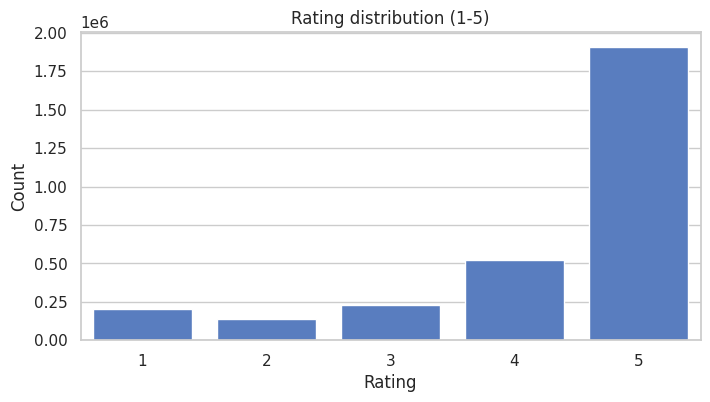

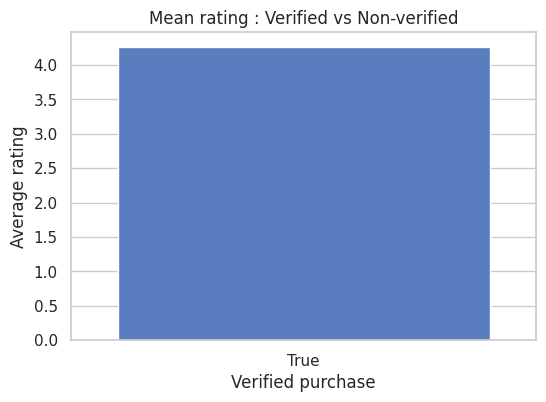

In [ ]:
# Ratings bar plot
plt.figure(figsize=(8,4))
sns.countplot(x='rating', data=df, order=sorted(df['rating'].dropna().unique()))
plt.title("Rating distribution (1-5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Verified vs non-verified mean rating
agg = df.groupby('verified')['rating'].agg(['count','mean']).reset_index()
# don't rename, use 'mean' directly
plt.figure(figsize=(6,4))
sns.barplot(x='verified', y='mean', data=agg)
plt.title('Mean rating : Verified vs Non-verified')
plt.xlabel('Verified purchase')
plt.ylabel('Average rating')
plt.show()



In [ ]:
print("Unique values (raw):", df['verified'].unique()[:20])
print("Value counts (as strings):")
display(df['verified'].astype(str).value_counts(dropna=False))


Unique values (raw): [ True]
Value counts (as strings):


,count
verified,
True,3000000


In [ ]:
# Install packages if needed (Colab)
!pip install -q vaderSentiment wordcloud

# Imports
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr, spearmanr

sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10,6)
tqdm.pandas()

# Choose which DF to analyze: full df or the sampled `sample_df` used earlier.
# If you want to analyze the full dataset (may be slow), use `df`. For faster runs use sample_df.
if 'sample_df' in globals():
    ANALYZE_DF = sample_df  # faster, already sampled & cleaned earlier
else:
    ANALYZE_DF = df         # fallback to full df (may be heavy)

print("Using DataFrame with", len(ANALYZE_DF), "rows for analysis.")


Using DataFrame with 3000000 rows for analysis.


In [ ]:
# Create cleaned text (if missing) and length features
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text_simple(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

if 'text_clean' not in ANALYZE_DF.columns:
    print("Creating text_clean column (may take some time)...")
    ANALYZE_DF['text'] = ANALYZE_DF.get('text', ANALYZE_DF.get('reviewText','')).astype(str)
    ANALYZE_DF['text_clean'] = ANALYZE_DF['text'].progress_apply(clean_text_simple)
else:
    # Ensure no nulls
    ANALYZE_DF['text_clean'] = ANALYZE_DF['text_clean'].fillna('').astype(str)

# length features
ANALYZE_DF['n_chars'] = ANALYZE_DF['text_clean'].str.len()
ANALYZE_DF['n_words'] = ANALYZE_DF['text_clean'].str.split().apply(lambda lst: len(lst) if isinstance(lst, list) else 0)

# quick sanity
print("Lengths: n_chars mean", int(ANALYZE_DF['n_chars'].mean()), "n_words mean", int(ANALYZE_DF['n_words'].mean()))
display(ANALYZE_DF[['n_chars','n_words']].describe().round(1))


Creating text_clean column (may take some time)...


  0%|          | 0/3000000 [00:00<?, ?it/s]

Lengths: n_chars mean 197 n_words mean 37


,n_chars,n_words
count,3000000.0,3000000.0
mean,197.0,37.8
std,454.0,88.2
min,0.0,0.0
25%,26.0,4.0
50%,49.0,8.0
75%,177.0,35.0
max,31379.0,5927.0


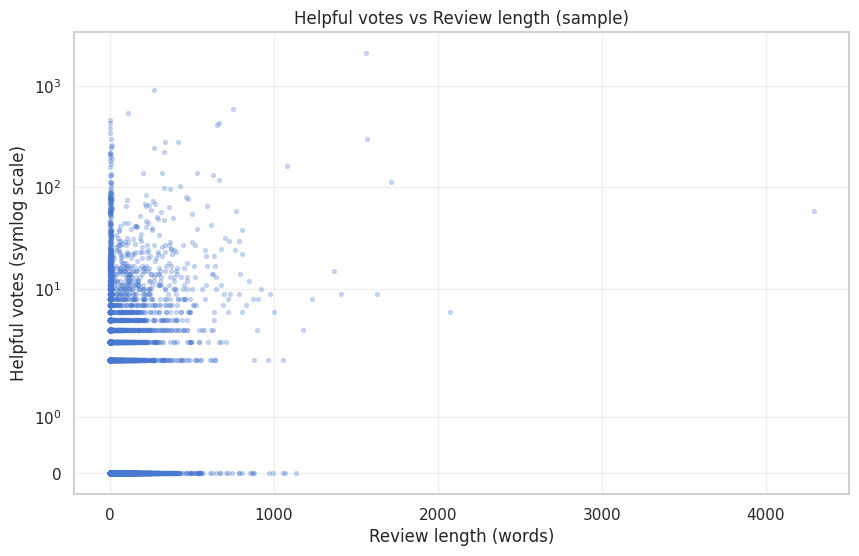

/tmp/ipython-input-3130115130.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = sample_for_plot.groupby('word_bin')['vote'].median().reset_index()


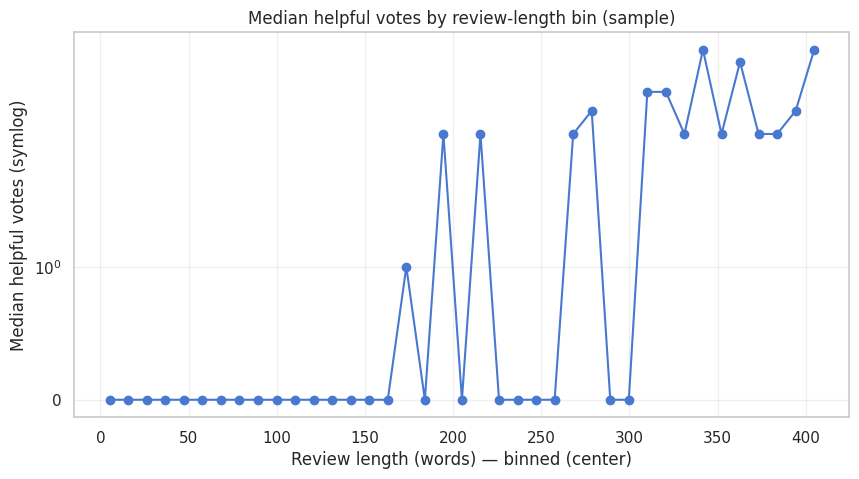

Pearson correlation (n_words vs vote): 0.1324
Spearman correlation (n_words vs vote): 0.1759


In [ ]:
# We'll use a smaller subset to draw scatter (avoid plotting millions of points).
# Option: sample_for_plot = ANALYZE_DF.sample(n=20000, random_state=42)
sample_for_plot = ANALYZE_DF.sample(n=min(20000, len(ANALYZE_DF)), random_state=42)

# Plot scatter: votes vs words (jitter / alpha)
plt.figure(figsize=(10,6))
plt.scatter(sample_for_plot['n_words'], sample_for_plot['vote'], alpha=0.25, s=8)
plt.yscale('symlog')  # show tail but compress very large counts
plt.xlabel('Review length (words)')
plt.ylabel('Helpful votes (symlog scale)')
plt.title('Helpful votes vs Review length (sample)')
plt.grid(True, alpha=0.3)
plt.show()

# Add a binned summary (median votes per length bin)
bins = np.linspace(0, sample_for_plot['n_words'].quantile(0.99), 40)
sample_for_plot['word_bin'] = pd.cut(sample_for_plot['n_words'], bins=bins, include_lowest=True)
binned = sample_for_plot.groupby('word_bin')['vote'].median().reset_index()
binned['bin_center'] = binned['word_bin'].apply(lambda r: r.mid)
plt.figure(figsize=(10,5))
plt.plot(binned['bin_center'], binned['vote'], marker='o')
plt.yscale('symlog')
plt.xlabel('Review length (words) — binned (center)')
plt.ylabel('Median helpful votes (symlog)')
plt.title('Median helpful votes by review-length bin (sample)')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation (use Spearman, since vote is heavy-tailed and not normally distributed)
valid = ANALYZE_DF[['n_words','vote']].dropna()
pearson_corr = pearsonr(valid['n_words'], valid['vote'])[0]
spearman_corr = spearmanr(valid['n_words'], valid['vote']).correlation
print(f"Pearson correlation (n_words vs vote): {pearson_corr:.4f}")
print(f"Spearman correlation (n_words vs vote): {spearman_corr:.4f}")


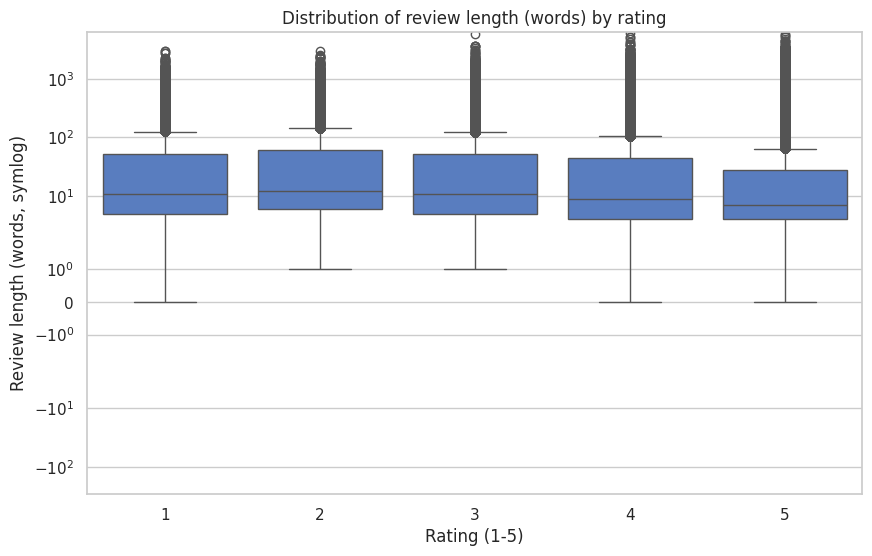

,rating,count,median,mean,std
0,1,205790,11.0,45.72,87.24
1,2,136168,12.0,53.00,100.45
2,3,228272,11.0,50.31,105.52
3,4,520339,9.0,48.36,110.05
4,5,1909431,7.0,31.47,76.99


In [ ]:
# Boxplot of n_words by rating
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', y='n_words', data=ANALYZE_DF[ANALYZE_DF['rating'].notnull()])
plt.yscale('symlog')  # compress extreme lengths if present
plt.title('Distribution of review length (words) by rating')
plt.xlabel('Rating (1-5)')
plt.ylabel('Review length (words, symlog)')
plt.show()

# Aggregate stats: mean/median length by rating
len_stats = ANALYZE_DF.groupby('rating')['n_words'].agg(['count','median','mean','std']).reset_index().sort_values('rating')
display(len_stats.round(2))


Computing VADER scores (this may take a while)...


  0%|          | 0/3000000 [00:00<?, ?it/s]

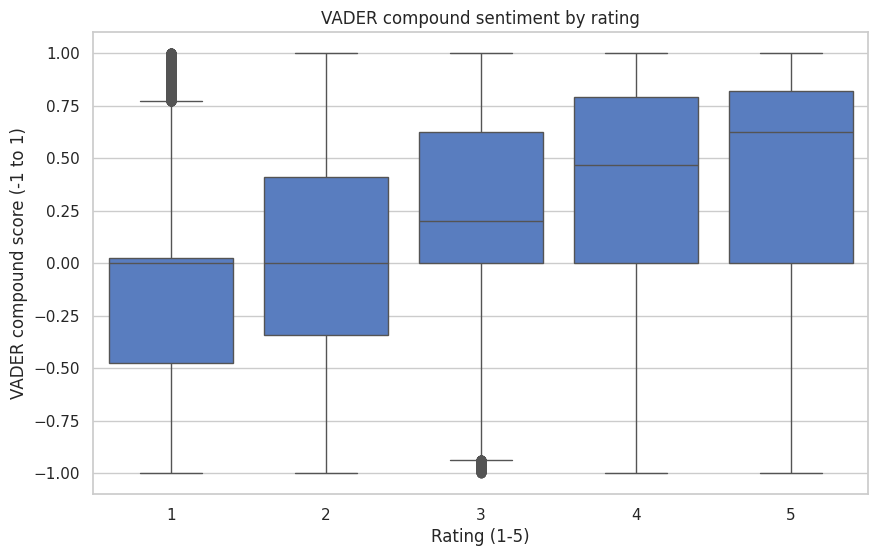

Pearson corr (rating vs VADER): 0.4000
Spearman corr (rating vs VADER): 0.2940


,rating,count,mean,median,std
0,1,205790,-0.111,0.000,0.478
1,2,136168,0.040,0.000,0.498
2,3,228272,0.229,0.202,0.464
3,4,520339,0.442,0.468,0.400
4,5,1909431,0.494,0.625,0.373


In [ ]:
# compute VADER compound (if not computed)
analyzer = SentimentIntensityAnalyzer()
if 'vader_compound' not in ANALYZE_DF.columns:
    print("Computing VADER scores (this may take a while)...")
    ANALYZE_DF['vader_compound'] = ANALYZE_DF['text_clean'].progress_apply(lambda t: analyzer.polarity_scores(t)['compound'])
else:
    print("vader_compound column already exists.")

# Boxplot of VADER by rating
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', y='vader_compound', data=ANALYZE_DF[ANALYZE_DF['rating'].notnull()])
plt.title('VADER compound sentiment by rating')
plt.xlabel('Rating (1-5)')
plt.ylabel('VADER compound score (-1 to 1)')
plt.show()

# Correlation rating vs vader
valid_sent = ANALYZE_DF[['rating','vader_compound']].dropna()
pearson_sent = pearsonr(valid_sent['rating'].astype(float), valid_sent['vader_compound'])[0]
spearman_sent = spearmanr(valid_sent['rating'].astype(float), valid_sent['vader_compound']).correlation
print(f"Pearson corr (rating vs VADER): {pearson_sent:.4f}")
print(f"Spearman corr (rating vs VADER): {spearman_sent:.4f}")

# Summarize average VADER per rating
vader_by_rating = ANALYZE_DF.groupby('rating')['vader_compound'].agg(['count','mean','median','std']).reset_index().sort_values('rating')
display(vader_by_rating.round(3))


,rating,vote,n_words,votes_per_100_words,text
0,4,9096,4,227400.000000,1300147200. A Step Closer
1,4,9096,4,227400.000000,1300147200. A Step Closer
2,5,3068,4,76700.000000,1214784000. Garmin Nuvi 255w
3,5,3068,4,76700.000000,1214784000. Garmin Nuvi 255w
4,5,2058,3,68600.000000,"1221523200. Almost ""Untouchable"""
5,4,3982,7,56885.714286,1270252800. A leap in the right direction
6,5,2209,4,55225.000000,"1243296000. Excellent, Compact Camcorder"
7,3,2016,4,50400.000000,"1253750400. Great radios, BUT"
8,4,1990,4,49750.000000,1255651200. Very good but . . . .
9,5,2838,6,47300.000000,1253577600. Excellent features and amazing range


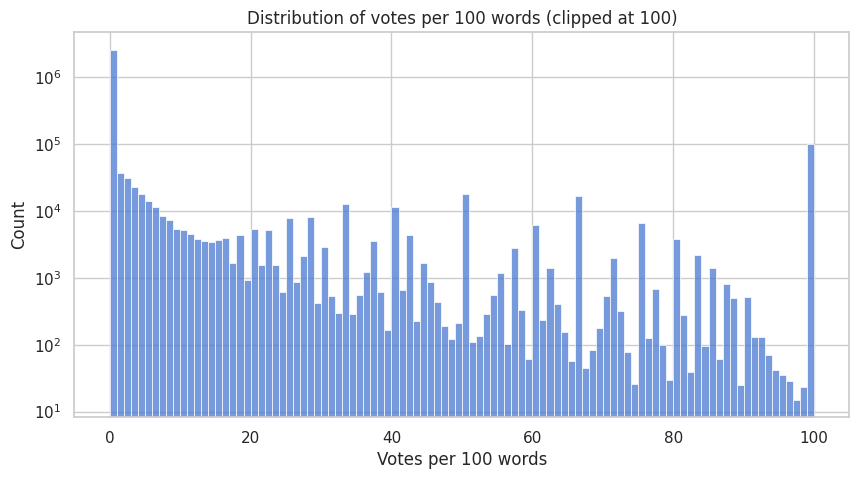

In [ ]:
# Compute votes per 100 words (avoid divide-by-zero)
ANALYZE_DF['votes_per_100_words'] = ANALYZE_DF['vote'] / (ANALYZE_DF['n_words'].replace(0, np.nan) / 100.0)
# Replace inf/nan with 0 where n_words was 0
ANALYZE_DF['votes_per_100_words'] = ANALYZE_DF['votes_per_100_words'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Top reviews by votes_per_100_words (potential highly useful short reviews)
top_normalized = ANALYZE_DF.sort_values('votes_per_100_words', ascending=False).head(20)[['rating','vote','n_words','votes_per_100_words','text']].reset_index(drop=True)
display(top_normalized)

# Plot votes_per_100_words distribution (clip extreme tail for visualization)
plt.figure(figsize=(10,5))
sns.histplot(ANALYZE_DF['votes_per_100_words'].clip(upper=100), bins=100)
plt.title('Distribution of votes per 100 words (clipped at 100)')
plt.xlabel('Votes per 100 words')
plt.yscale('log')
plt.show()


In [ ]:
OUT_DIR = "/content/drive/My Drive/Amazon-Analysis/analysis_outputs"
import os
os.makedirs(OUT_DIR, exist_ok=True)

# Save aggregated stats
len_stats.to_csv(os.path.join(OUT_DIR, "length_stats_by_rating.csv"), index=False)
vader_by_rating.to_csv(os.path.join(OUT_DIR, "vader_stats_by_rating.csv"), index=False)

# Save top normalized helpful reviews
top_normalized.to_csv(os.path.join(OUT_DIR, "top_votes_per_100_words.csv"), index=False)

print("Saved outputs to", OUT_DIR)


Saved outputs to /content/drive/My Drive/Amazon-Analysis/analysis_outputs


In [ ]:
# Install required packages (run once)
!pip install -q spacy vaderSentiment lightgbm wordcloud sentence-transformers
!python -m spacy download en_core_web_sm

# NLTK for stopwords if needed
!pip install -q nltk
import nltk
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 123.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"  # update if necessary

import pandas as pd
print("Loading CSV (may take ~30s)...")
df = pd.read_csv(DATA_PATH, low_memory=False, usecols=['overall','vote','verified','reviewTime','reviewText','summary'])
df.rename(columns={'overall':'rating'}, inplace=True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('Int64')
df['vote'] = pd.to_numeric(df['vote'], errors='coerce').fillna(0).astype(int)
df['reviewTime_parsed'] = pd.to_datetime(df['reviewTime'], errors='coerce')
df['summary'] = df['summary'].fillna('').astype(str)
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df['text'] = (df['summary'].str.strip() + ". " + df['reviewText'].str.strip()).str.strip()

print("Total rows:", len(df))
df.head(2)


Loading CSV (may take ~30s)...
Total rows: 3000000


,rating,vote,verified,reviewTime,reviewText,summary,reviewTime_parsed,text
0,5,67,True,1999-09-18,This is the best novel I have read in 2 or 3 y...,A star is born,1999-09-18,A star is born. This is the best novel I have ...
1,3,5,True,2013-10-23,"Pages and pages of introspection, in the style...",A stream of consciousness novel,2013-10-23,A stream of consciousness novel. Pages and pag...


In [ ]:
# Use sample for NLP-heavy tasks
SAMPLE_SIZE = 200_000  # change smaller if you run out of memory
if len(df) > SAMPLE_SIZE:
    sample_df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
else:
    sample_df = df.copy()

print("Using sample size:", len(sample_df))

# Basic cleaned text
import re
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>',' ', s)
    s = re.sub(r'[^a-z0-9\s]',' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s

sample_df['text_clean'] = sample_df['text'].progress_apply(clean_text) if 'progress_apply' in dir(sample_df['text']) else sample_df['text'].apply(clean_text)
sample_df['n_words'] = sample_df['text_clean'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)
sample_df['n_chars'] = sample_df['text_clean'].str.len()
sample_df.head(1)


Using sample size: 200000


  0%|          | 0/200000 [00:00<?, ?it/s]

,rating,vote,verified,reviewTime,reviewText,summary,reviewTime_parsed,text,text_clean,n_words,n_chars
0,5,0,True,2017-07-17,Works great and much larger capacity that Sony...,Five Stars,2017-07-17,Five Stars. Works great and much larger capaci...,five stars works great and much larger capacit...,13,76


In [ ]:
# Fixed noun_chunk extraction (fast, uses nlp.pipe)
import spacy
from collections import Counter
from tqdm.auto import tqdm

# Load model with parser enabled (don't disable 'parser')
# We disable only 'ner' to save some time; keep POS and dependency parse.
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# If you previously added a sentencizer, it's fine; not required for noun_chunks.
# nlp.add_pipe("sentencizer")  # optional

# Aspect keywords (same as before, extend if needed)
ASPECT_KEYWORDS = ["battery","screen","display","sound","speaker","camera","price",
                   "delivery","shipping","service","quality","battery life","charging",
                   "charger","warranty","performance","design","size"]

# Make sure texts are strings
texts = sample_df['text_clean'].astype(str).tolist()
noun_chunks_list = []

# Use nlp.pipe for speed. Adjust batch_size and n_process for your runtime.
# - batch_size: number of docs per batch
# - n_process: multiprocessing workers (set to 1 if multiprocessing causes issues)
batch_size = 500
n_process = 2  # set 1 on Colab CPU-only if you see issues

for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts), desc="spaCy pipe"):
    # Collect noun_chunks (lowercased)
    chunks = [chunk.text.strip().lower() for chunk in doc.noun_chunks if len(chunk.text.strip()) > 1]
    noun_chunks_list.append(chunks)

# Assign back to dataframe
sample_df['noun_chunks'] = noun_chunks_list

# Now count aspect keyword mentions per review
def count_aspects(chunks):
    c = Counter()
    for ch in chunks:
        for kw in ASPECT_KEYWORDS:
            if kw in ch:
                c[kw] += 1
    return dict(c)

sample_df['aspect_counts'] = sample_df['noun_chunks'].apply(count_aspects)

# Quick aggregate to see top aspect keywords in the sample
agg_counts = Counter()
for d in sample_df['aspect_counts']:
    agg_counts.update(d)

print("Top aspect keyword counts:")
for k, v in agg_counts.most_common(30):
    print(f"{k}: {v}")


spaCy pipe:   0%|          | 0/200000 [00:00<?, ?it/s]

Top aspect keyword counts:
price: 21078
quality: 19397
camera: 18576
sound: 15714
speaker: 10309
battery: 8132
screen: 7713
size: 5521
design: 3559
charger: 3153
service: 2625
performance: 2538
display: 1793
shipping: 1631
warranty: 1489
battery life: 1421
delivery: 893
charging: 668


In [ ]:
# --- Fixed: Aspect sentiment extraction using spaCy sentencizer + VADER (fast, avoids NLTK) ---
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

# Ensure spaCy model available
# !python -m spacy download en_core_web_sm   # uncomment if not installed

# Load spaCy with parser enabled (so doc.sents works). Disable NER to save a little time.
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# Aspect keywords (same list used earlier)
ASPECT_KEYWORDS = ["battery","screen","display","sound","speaker","camera","price",
                   "delivery","shipping","service","quality","battery life","charging",
                   "charger","warranty","performance","design","size"]

analyzer = SentimentIntensityAnalyzer()

# Convert texts to list (ensure string type)
texts = sample_df['text'].fillna('').astype(str).tolist()

# We'll create a list of aspect-sentiment pairs per review
aspect_sent_pairs_list = []

# Tune these for speed / CPU usage:
batch_size = 300        # docs processed per batch
n_process = 1           # set to 1 on Colab to avoid multiprocessing issues

# Process with nlp.pipe (streaming)
for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts), desc="spaCy sentences"):
    pairs = []
    # iterate sentences from spaCy
    for sent in doc.sents:
        stext = sent.text.strip()
        if not stext:
            continue
        s_low = stext.lower()
        # check aspect keywords presence
        for kw in ASPECT_KEYWORDS:
            if kw in s_low:
                comp = analyzer.polarity_scores(stext)['compound']
                pairs.append((kw, comp))
    aspect_sent_pairs_list.append(pairs)

# Attach to dataframe
sample_df['aspect_sent_pairs'] = aspect_sent_pairs_list

# Quick aggregation to confirm results
from collections import defaultdict
import numpy as np

aspect_sent_agg = defaultdict(list)
for pairs in sample_df['aspect_sent_pairs']:
    for asp, comp in pairs:
        aspect_sent_agg[asp].append(comp)

aspect_summary = []
for asp, comps in aspect_sent_agg.items():
    comps_arr = np.array(comps)
    aspect_summary.append({
        "aspect": asp,
        "mentions": int(len(comps_arr)),
        "mean_compound": float(comps_arr.mean()),
        "median_compound": float(np.median(comps_arr)),
        "pct_positive": float((comps_arr > 0.05).mean())
    })

aspect_df = pd.DataFrame(aspect_summary).sort_values('mentions', ascending=False).reset_index(drop=True)
display(aspect_df.head(30))
print("Done — saved sentence-level aspect sentiment into sample_df['aspect_sent_pairs'].")


spaCy sentences:   0%|          | 0/200000 [00:00<?, ?it/s]

,aspect,mentions,mean_compound,median_compound,pct_positive
0,price,23191,0.414650,0.4927,0.754431
1,quality,20475,0.322499,0.4404,0.672527
2,sound,20100,0.362419,0.4576,0.710398
3,camera,17826,0.238519,0.2500,0.558678
4,speaker,9743,0.277728,0.3400,0.599199
5,battery,7859,0.161897,0.0000,0.470416
6,screen,7398,0.207584,0.1406,0.522709
7,size,5851,0.287774,0.3612,0.606563
8,design,5175,0.230545,0.2732,0.578937
9,charger,3146,0.202035,0.1027,0.514622


Done — saved sentence-level aspect sentiment into sample_df['aspect_sent_pairs'].


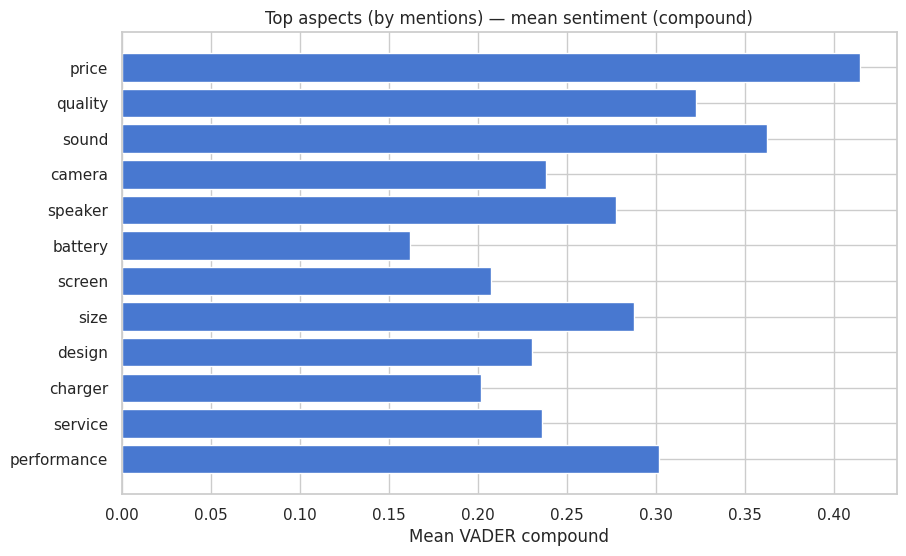

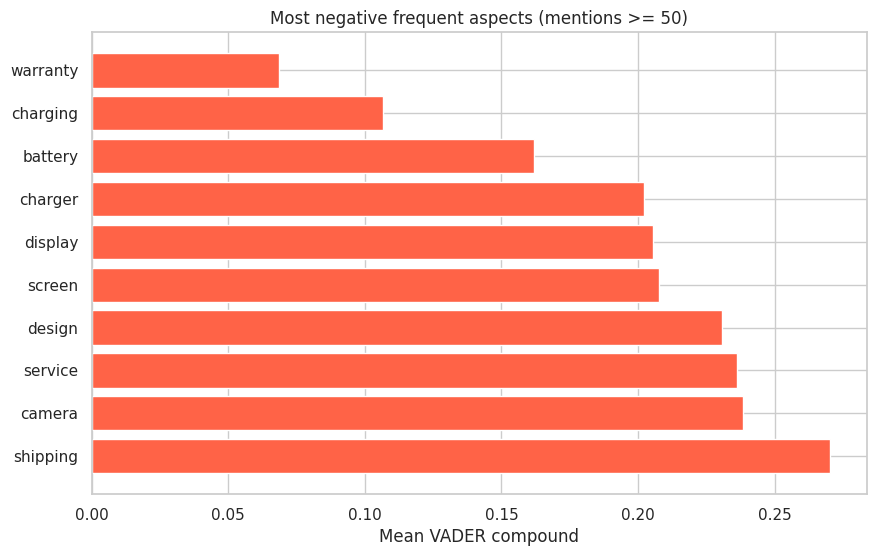

In [ ]:
import matplotlib.pyplot as plt
# Top 12 by mentions
top_aspects = aspect_df.head(12)
plt.figure(figsize=(10,6))
plt.barh(top_aspects['aspect'][::-1], top_aspects['mean_compound'][::-1])
plt.xlabel('Mean VADER compound')
plt.title('Top aspects (by mentions) — mean sentiment (compound)')
plt.show()

# Show most negative aspects (with >= some mentions)
neg = aspect_df[aspect_df['mentions']>=50].sort_values('mean_compound').head(10)
plt.figure(figsize=(10,6))
plt.barh(neg['aspect'][::-1], neg['mean_compound'][::-1], color='tomato')
plt.xlabel('Mean VADER compound')
plt.title('Most negative frequent aspects (mentions >= 50)')
plt.show()


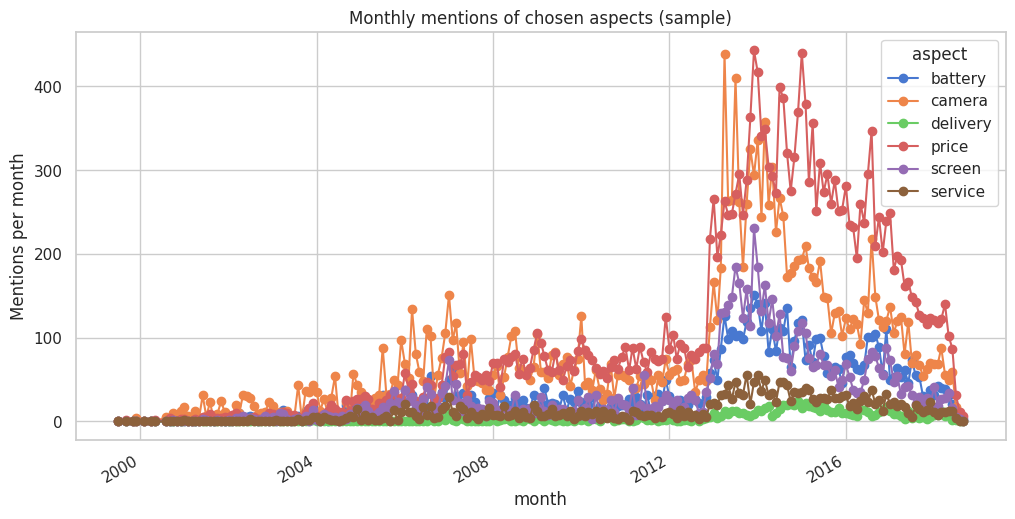

In [ ]:
# Choose aspects to track
track_aspects = ['battery','screen','price','delivery','service','camera']

# Expand sample_df into rows per aspect mention with date + sentiment
rows = []
for idx, row in sample_df.iterrows():
    dt = row['reviewTime_parsed']
    if pd.isna(dt):
        continue
    for asp, comp in row['aspect_sent_pairs']:
        if asp in track_aspects:
            rows.append({'date': dt.date(), 'aspect': asp, 'compound': comp})
asp_time_df = pd.DataFrame(rows)
if len(asp_time_df)==0:
    print("No aspect timeline rows found — try lowering min filters or check dates.")
else:
    asp_time_df['month'] = pd.to_datetime(asp_time_df['date']).dt.to_period('M').dt.to_timestamp()
    monthly = asp_time_df.groupby(['month','aspect']).size().reset_index(name='count')
    # Pivot for plotting
    pivot = monthly.pivot(index='month', columns='aspect', values='count').fillna(0)
    pivot.plot(kind='line', figsize=(12,6), marker='o')
    plt.title('Monthly mentions of chosen aspects (sample)')
    plt.ylabel('Mentions per month')
    plt.show()


In [ ]:
# Prepare label
THRESHOLD = sample_df['vote'].median()  # median threshold
sample_df['high_helpful'] = (sample_df['vote'] >= THRESHOLD).astype(int)
print("Threshold (median):", THRESHOLD)
print("Class distribution:\n", sample_df['high_helpful'].value_counts(normalize=True))

# Feature: TF-IDF on text_clean (use limited max_features), plus length & sentiment
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# small TF-IDF to keep memory moderate
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=5, stop_words='english')
X_tfidf = tfidf.fit_transform(sample_df['text_clean'])

# compute VADER compound if not already (we did for aspects earlier per sentence; compute overall compound)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sample_df['vader_compound_overall'] = sample_df['text_clean'].progress_apply(lambda t: analyzer.polarity_scores(t)['compound'])

# Combine features: TF-IDF + numeric features
import scipy.sparse as sps
numeric_feats = sample_df[['n_words','n_chars','vader_compound_overall']].fillna(0).astype(float).values
X = sps.hstack([X_tfidf, sps.csr_matrix(numeric_feats)], format='csr')
y = sample_df['high_helpful'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Threshold (median): 0.0
Class distribution:
 high_helpful
1    1.0
Name: proportion, dtype: float64


100%|██████████| 200000/200000 [01:08<00:00, 2935.84it/s]


Train shape: (160000, 30003) Test shape: (40000, 30003)


In [ ]:
import lightgbm as lgb
print("Using lgb.train with callbacks...")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'verbosity': -1,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'bagging_freq': 1,
    'bagging_fraction': 0.7,
    'seed': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Use callbacks for early stopping and periodic logging
bst = lgb.train(
    params,
    train_data,
    num_boost_round=200,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)]
)

# Predict & evaluate
y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)


Using lgb.train with callbacks...
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's auc: 1


AUC: nan
Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000     40000

    accuracy                         1.0000     40000
   macro avg     1.0000    1.0000    1.0000     40000
weighted avg     1.0000    1.0000    1.0000     40000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


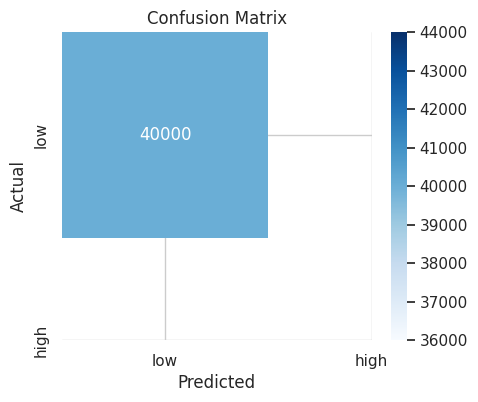

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_pred_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low','high'], yticklabels=['low','high'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Get feature importances (top numeric + top tfidf tokens)
imp = bst.feature_importance(importance_type='gain')
feat_names = tfidf.get_feature_names_out().tolist() + ['n_words','n_chars','vader_compound_overall']
imp_df = pd.DataFrame({'feature': feat_names, 'importance': imp}).sort_values('importance', ascending=False).head(40)
display(imp_df)

# Save top textual features separately
top_tfidf = imp_df[imp_df['feature'].isin(tfidf.get_feature_names_out())].head(30)
print("Top textual features by importance (sample):")
display(top_tfidf)


,feature,importance
30002,vader_compound_overall,0.0
0,00,0.0
1,000,0.0
2,000 000,0.0
3,000 hours,0.0
4,01,0.0
5,02,0.0
6,03,0.0
7,04,0.0
8,05,0.0


Top textual features by importance (sample):


,feature,importance
0,00,0.0
1,000,0.0
2,000 000,0.0
3,000 hours,0.0
4,01,0.0
5,02,0.0
6,03,0.0
7,04,0.0
8,05,0.0
9,06,0.0


In [ ]:
import joblib, os
OUT = "/content/drive/My Drive/Amazon-Analysis/advanced_outputs"
os.makedirs(OUT, exist_ok=True)

joblib.dump(tfidf, os.path.join(OUT, "tfidf_30000.joblib"))
bst.save_model(os.path.join(OUT, "lgb_helpful_model.txt"))
joblib.dump(bst, os.path.join(OUT, "lgb_helpful_model.pkl"))  # lightweight pickle

aspect_df.to_csv(os.path.join(OUT, "aspect_sentiment_summary.csv"), index=False)
print("Saved TF-IDF, LightGBM model, and aspect summary to", OUT)


Saved TF-IDF, LightGBM model, and aspect summary to /content/drive/My Drive/Amazon-Analysis/advanced_outputs


In [ ]:
# Path to your CSV (update if needed)
DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"

# Load only needed columns initially to save memory (we'll load text too)
import pandas as pd
print("Loading head to detect columns (fast)...")
df_head = pd.read_csv(DATA_PATH, nrows=5)
print("Columns available:", df_head.columns.tolist())

# Detect product id column automatically (common names)
candidate_cols = ['asin','ASIN','productID','product_id','productId','product','item_id','id']
prod_col = None
for c in candidate_cols:
    if c in df_head.columns:
        prod_col = c
        break

if prod_col is None:
    # fallback: list all columns and pick one with many unique values later
    print("No obvious product id column found in head. Will try to detect after loading...")
else:
    print("Detected product id column:", prod_col)


Loading head to detect columns (fast)...
Columns available: ['overall', 'vote', 'verified', 'reviewTime', 'reviewText', 'summary']
No obvious product id column found in head. Will try to detect after loading...


In [ ]:
# Safe diagnostics & fallback for product-level pipeline

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"  # update if needed

import pandas as pd, numpy as np
pd.options.display.max_columns = 60
pd.options.display.max_colwidth = 200

# 1) Load a small head first to inspect columns
print("Reading header (first 5 rows) to inspect columns...")
df_head = pd.read_csv(DATA_PATH, nrows=5)
print("Columns:", df_head.columns.tolist())
display(df_head)

# 2) Load dataset but only required columns; parse dates robustly as strings first
print("\nLoading required columns (this may take a bit)...")
usecols = None  # read all columns here (we'll inspect)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded rows:", len(df))
print("Columns present:", df.columns.tolist())

# 3) Try robust date parsing for reviewTime
if 'reviewTime' in df.columns:
    # ensure string -> then to_datetime (this avoids pandas weird assembly errors)
    df['reviewTime_str'] = df['reviewTime'].astype(str).str.strip()
    df['reviewTime_parsed'] = pd.to_datetime(df['reviewTime_str'], errors='coerce', dayfirst=False)
    print("Parsed reviewTime. Parsed count (non-null):", df['reviewTime_parsed'].notnull().sum())
else:
    print("No 'reviewTime' column found.")

# 4) Show unique counts for each column to help identification (top 10 unique values)
print("\nColumn unique counts and sample values (top 10 shown):")
col_info = []
for c in df.columns:
    nunique = df[c].nunique(dropna=False)
    sample_vals = df[c].dropna().unique()[:10].tolist()
    col_info.append((c, nunique, sample_vals))
info_df = pd.DataFrame(col_info, columns=['column','nunique','sample_values'])
display(info_df.sort_values('nunique', ascending=False).head(50))

# 5) Try to detect product id explicitly by common column names
candidates = ['asin','ASIN','productID','product_id','productId','product','item_id','id']
found = [c for c in candidates if c in df.columns]
if found:
    print("FOUND product-id candidate columns:", found)
else:
    print("No common product-id column names found in this CSV. (So product-level aggregation is not possible from this file.)")

# 6) If product id not found, show next best columns that might be used (columns having many unique values)
if not found:
    # list top columns by unique counts but exclude text columns that obviously aren't ids
    ignore_cols = set(['reviewText','summary','text','reviewTime','reviewTime_str','reviewTime_parsed'])
    cand_df = info_df[~info_df['column'].isin(ignore_cols)].sort_values('nunique', ascending=False)
    print("\nColumns with high uniqueness (may be candidate ids):")
    display(cand_df.head(10))

# 7) Summary message / suggested next steps
if found:
    prod_col = found[0]
    print(f"\nGood — we can compute product-level summaries using column: {prod_col}")
    # you can continue with the product-level pipeline using prod_col
else:
    print("\nNo explicit product-id column found. Options:")
    print("A) If you have the original Electronics file that includes 'asin', please load that CSV (it will allow accurate product-level aggregation).")
    print("B) I can compute dataset-level quality / time-trends and extract pros/cons, or")
    print("C) we can attempt an approximate 'pseudo-product' grouping by clustering review embeddings (experimental).")
    print("Tell me which option (A/B/C) you prefer, or upload the file that includes 'asin' and I'll run the product-level pipeline.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading header (first 5 rows) to inspect columns...
Columns: ['overall', 'vote', 'verified', 'reviewTime', 'reviewText', 'summary']


,overall,vote,verified,reviewTime,reviewText,summary
0,5,67,True,1999-09-18,"This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- hi...",A star is born
1,3,5,True,2013-10-23,"Pages and pages of introspection, in the style of writers like Henry James. I like this kind of novels and the writer occasionally delights me with her descriptions and observations. But it's w...",A stream of consciousness novel
2,5,4,True,2008-09-02,"This is the kind of novel to read when you have time to lose yourself in a book for days, possibly weeks. I had to go back and reread it as soon as I finished it because it is so rich in historica...",I'm a huge fan of the author and this one did not disappoint
3,5,13,True,2000-09-04,"What gorgeous language! What an incredible writer! The Last Life is one of the best written novels I have ever read. This incredible novel contains various elements of fiction: historical, philo...",The most beautiful book I have ever read!
4,3,8,True,2000-02-04,I was taken in by reviews that compared this book with The Leopard or promised a bildungsroman set in a family that is isolated and on the move. Well...I didn't feel any parallel with The Leopard...,A dissenting view--In part.



Loading required columns (this may take a bit)...
Loaded rows: 3000000
Columns present: ['overall', 'vote', 'verified', 'reviewTime', 'reviewText', 'summary']
Parsed reviewTime. Parsed count (non-null): 3000000

Column unique counts and sample values (top 10 shown):


,column,nunique,sample_values
4,reviewText,2036707,"[This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- h..."
5,summary,827727,"[A star is born, A stream of consciousness novel, I'm a huge fan of the author and this one did not disappoint, The most beautiful book I have ever read!, A dissenting view--In part., Above averag..."
3,reviewTime,6832,"[1999-09-18, 2013-10-23, 2008-09-02, 2000-09-04, 2000-02-04, 2013-06-05, 2016-06-27, 2015-07-30, 2015-02-16, 2013-11-21]"
6,reviewTime_str,6832,"[1999-09-18, 2013-10-23, 2008-09-02, 2000-09-04, 2000-02-04, 2013-06-05, 2016-06-27, 2015-07-30, 2015-02-16, 2013-11-21]"
7,reviewTime_parsed,6832,"[1999-09-18 00:00:00, 2013-10-23 00:00:00, 2008-09-02 00:00:00, 2000-09-04 00:00:00, 2000-02-04 00:00:00, 2013-06-05 00:00:00, 2016-06-27 00:00:00, 2015-07-30 00:00:00, 2015-02-16 00:00:00, 2013-1..."
1,vote,903,"[67, 5, 4, 13, 8, 0, 2, 12, 3, 46]"
0,overall,5,"[5, 3, 4, 2, 1]"
2,verified,1,[True]


No common product-id column names found in this CSV. (So product-level aggregation is not possible from this file.)

Columns with high uniqueness (may be candidate ids):


,column,nunique,sample_values
1,vote,903,"[67, 5, 4, 13, 8, 0, 2, 12, 3, 46]"
0,overall,5,"[5, 3, 4, 2, 1]"
2,verified,1,[True]



No explicit product-id column found. Options:
A) If you have the original Electronics file that includes 'asin', please load that CSV (it will allow accurate product-level aggregation).
B) I can compute dataset-level quality / time-trends and extract pros/cons, or
C) we can attempt an approximate 'pseudo-product' grouping by clustering review embeddings (experimental).
Tell me which option (A/B/C) you prefer, or upload the file that includes 'asin' and I'll run the product-level pipeline.


In [ ]:
DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"
OUT_DIR = "/content/drive/My Drive/Amazon-Analysis/dataset_level_outputs"
import os
os.makedirs(OUT_DIR, exist_ok=True)

print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)

DATA_PATH: /content/drive/My Drive/Amazon-Analysis/electronics_small.csv
OUT_DIR: /content/drive/My Drive/Amazon-Analysis/dataset_level_outputs


In [ ]:
import pandas as pd, numpy as np, re
pd.options.display.max_colwidth = 200

# load only known columns to save memory
usecols = ['overall','vote','verified','reviewTime','reviewText','summary']
print("Loading CSV (may take 30-60s)...")
df = pd.read_csv(DATA_PATH, usecols=usecols, low_memory=False)

# normalize columns
df = df.rename(columns={'overall':'rating'})
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').astype('Float64')
df['vote'] = pd.to_numeric(df['vote'], errors='coerce').fillna(0).astype(int)
df['verified'] = df['verified'].astype(str).str.lower().map({'true':True,'false':False,'t':True,'f':False}).fillna(False)

# parse reviewTime safely
df['reviewTime_str'] = df['reviewTime'].astype(str).str.strip()
df['reviewTime_parsed'] = pd.to_datetime(df['reviewTime_str'], errors='coerce')

# create text
df['summary'] = df['summary'].fillna('').astype(str)
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df['text'] = (df['summary'].str.strip() + ". " + df['reviewText'].str.strip()).str.strip()

# lightweight cleaned text for token counts
def clean_text_simple(s):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>',' ', s)
    s = re.sub(r'[^a-z0-9\s]',' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s
df['text_clean'] = df['text'].astype(str).map(clean_text_simple)

# length features
df['n_chars'] = df['text_clean'].str.len()
df['n_words'] = df['text_clean'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0)

print("Loaded rows:", len(df))
display(df.head(3))


Loading CSV (may take 30-60s)...
Loaded rows: 3000000


,rating,vote,verified,reviewTime,reviewText,summary,reviewTime_str,reviewTime_parsed,text,text_clean,n_chars,n_words
0,5.0,67,True,1999-09-18,"This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers of meanings -- hi...",A star is born,1999-09-18,1999-09-18,"A star is born. This is the best novel I have read in 2 or 3 years. It is everything that fiction should be -- beautifully written, engaging, well-plotted and structured. It has several layers o...",a star is born this is the best novel i have read in 2 or 3 years it is everything that fiction should be beautifully written engaging well plotted and structured it has several layers of meanings...,1055,191
1,3.0,5,True,2013-10-23,"Pages and pages of introspection, in the style of writers like Henry James. I like this kind of novels and the writer occasionally delights me with her descriptions and observations. But it's w...",A stream of consciousness novel,2013-10-23,2013-10-23,"A stream of consciousness novel. Pages and pages of introspection, in the style of writers like Henry James. I like this kind of novels and the writer occasionally delights me with her descripti...",a stream of consciousness novel pages and pages of introspection in the style of writers like henry james i like this kind of novels and the writer occasionally delights me with her descriptions a...,473,87
2,5.0,4,True,2008-09-02,"This is the kind of novel to read when you have time to lose yourself in a book for days, possibly weeks. I had to go back and reread it as soon as I finished it because it is so rich in historica...",I'm a huge fan of the author and this one did not disappoint,2008-09-02,2008-09-02,"I'm a huge fan of the author and this one did not disappoint. This is the kind of novel to read when you have time to lose yourself in a book for days, possibly weeks. I had to go back and reread ...",i m a huge fan of the author and this one did not disappoint this is the kind of novel to read when you have time to lose yourself in a book for days possibly weeks i had to go back and reread it ...,2118,395


Ratings summary:
count    3000000.0
mean      4.263818
std        1.20079
min            1.0
25%            4.0
50%            5.0
75%            5.0
max            5.0
Name: rating, dtype: Float64

Rating counts:


,count
rating,
1.0,205790
2.0,136168
3.0,228272
4.0,520339
5.0,1909431


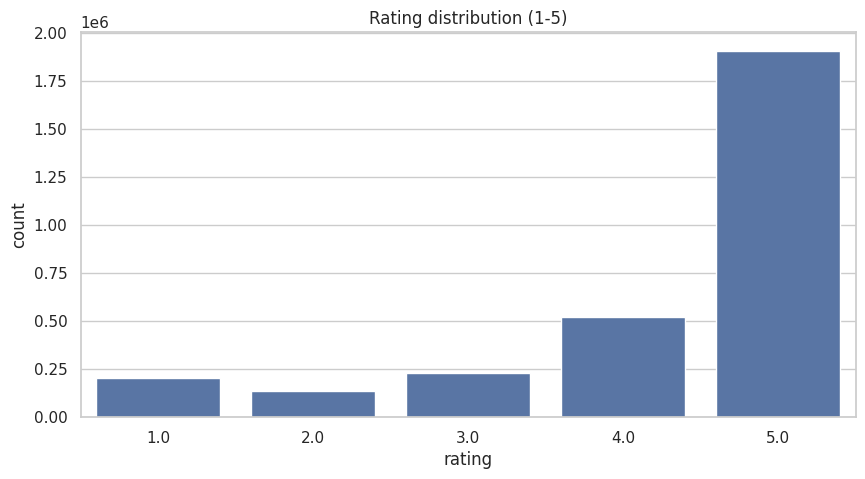

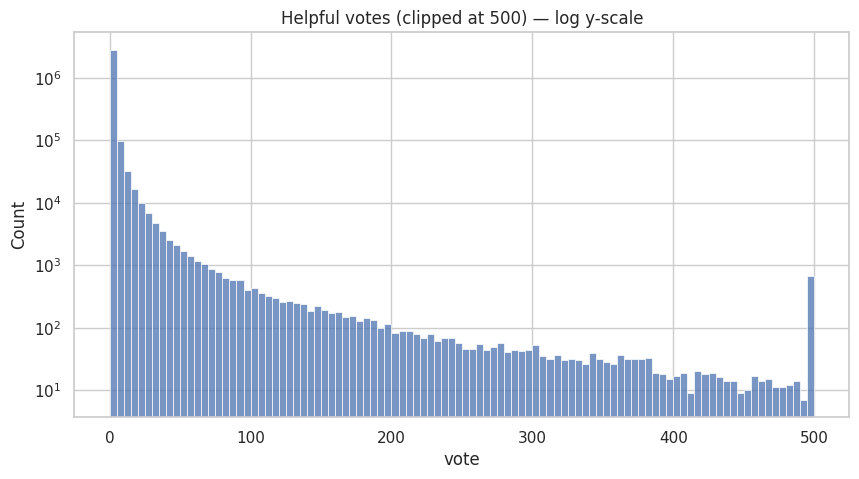


Verified value counts:


,count
verified,
True,3000000


In [ ]:
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

# Basic stats
print("Ratings summary:")
print(df['rating'].describe())
print("\nRating counts:")
display(df['rating'].value_counts().sort_index())

# Rating distribution plot
plt.figure()
sns.countplot(x='rating', data=df, order=sorted(df['rating'].dropna().unique()))
plt.title('Rating distribution (1-5)')
plt.show()

# Helpful votes distribution (clip tail for viz)
plt.figure()
sns.histplot(df['vote'].clip(upper=500), bins=100)
plt.yscale('log')
plt.title('Helpful votes (clipped at 500) — log y-scale')
plt.show()

# Verified counts (you observed all True previously)
print("\nVerified value counts:")
display(df['verified'].value_counts())


In [ ]:
import plotly.express as px

# drop NaT
ts_df = df.dropna(subset=['reviewTime_parsed']).set_index('reviewTime_parsed')

monthly_counts = ts_df.resample('M').size()
monthly_avg_rating = ts_df['rating'].resample('M').mean()

fig = px.line(x=monthly_counts.index, y=monthly_counts.values, labels={'x':'Month','y':'# reviews'}, title='Reviews per month (dataset)')
fig.show()

fig2 = px.line(x=monthly_avg_rating.index, y=monthly_avg_rating.values, labels={'x':'Month','y':'avg_rating'}, title='Average rating per month (dataset)')
fig2.show()

# Save small CSVs
monthly_counts.rename('count').to_csv(os.path.join(OUT_DIR, 'monthly_review_counts.csv'))
monthly_avg_rating.rename('avg_rating').to_csv(os.path.join(OUT_DIR, 'monthly_avg_rating.csv'))
print("Saved monthly CSVs to", OUT_DIR)


/tmp/ipython-input-3835985268.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = ts_df.resample('M').size()
/tmp/ipython-input-3835985268.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_rating = ts_df['rating'].resample('M').mean()


Saved monthly CSVs to /content/drive/My Drive/Amazon-Analysis/dataset_level_outputs


n_words stats:


,n_words
count,3000000.00
mean,37.79
std,88.16
min,0.00
25%,4.00
50%,8.00
75%,35.00
max,5927.00


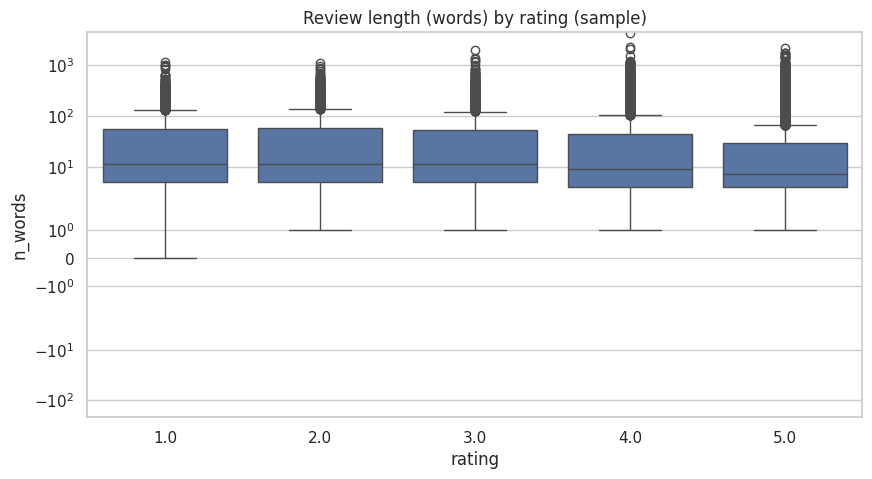

Pearson (n_words vs vote): 0.1324; Spearman: 0.1759


In [ ]:
from scipy.stats import spearmanr, pearsonr

print("n_words stats:")
display(df['n_words'].describe().round(2))

# boxplot n_words by rating (sampled for speed)
sample_vis = df.sample(n=min(50000, len(df)), random_state=42)
plt.figure()
sns.boxplot(x='rating', y='n_words', data=sample_vis)
plt.yscale('symlog')
plt.title('Review length (words) by rating (sample)')
plt.show()

# correlation between length and helpful votes
valid = df[['n_words','vote']].dropna()
pear = pearsonr(valid['n_words'], valid['vote'])[0]
spear = spearmanr(valid['n_words'], valid['vote']).correlation
print(f"Pearson (n_words vs vote): {pear:.4f}; Spearman: {spear:.4f}")


In [ ]:
# Top helpful reviews by raw votes
top_helpful = df.sort_values('vote', ascending=False).head(20)[['rating','vote','n_words','text','reviewTime_parsed']]
display(top_helpful)

# normalized helpfulness: votes per 100 words
df['votes_per_100_words'] = df['vote'] / (df['n_words'].replace(0, np.nan)/100.0)
df['votes_per_100_words'] = df['votes_per_100_words'].replace([np.inf, -np.inf], np.nan).fillna(0)
top_norm = df.sort_values('votes_per_100_words', ascending=False).head(40)[['rating','vote','n_words','votes_per_100_words','text']]
display(top_norm)
# Save top lists
top_helpful.to_csv(os.path.join(OUT_DIR, 'top_helpful_reviews_raw.csv'), index=False)
top_norm.to_csv(os.path.join(OUT_DIR, 'top_helpful_reviews_normalized.csv'), index=False)
print("Saved top-helpful CSVs.")


,rating,vote,n_words,text,reviewTime_parsed
1000773,4.0,9096,4,1300147200. A Step Closer,2011-03-15
812502,4.0,9096,4,1300147200. A Step Closer,2011-03-15
1696115,2.0,7739,2480,"Why does this now have over 4 THOUSAND negative reviews?. The Flex is fairly good - IF you understand its limitations. And it has a lot of them. This is a 1.0 version, the first wrist-based tracke...",2013-04-16
1694522,5.0,5203,1220,"New models available. UPDATE: November 20, 2015\n\nWow, these are coming fast and furious. Roku 4 is now here, It's more expensive but it's probably worth it because it adds lots of new capabiliti...",2013-03-06
2312849,5.0,4192,12,1260489600. Bose QC15 vs. Sennheiser PXC 450 vs. Audio-Technica ATH-ANC7b,2009-12-11
1341863,1.0,4146,16,"1275436800. Excellent sound quality, poor build quality. I've owned 3, and all 3 are dead.",2010-06-02
1303136,5.0,4041,9,1244851200. The best dashboard friction mount that Garmin makes,2009-06-13
1436074,4.0,3982,7,1270252800. A leap in the right direction,2010-04-03
1379525,5.0,3587,12,1257552000. The camcorder SHOWDOWN: I've done the product comparisons for you,2009-11-07
1866138,5.0,3269,34,"Fantastic!. I purchased this for my Atari 2600 and wow did it make a difference! Also, I am very thankful that it has low energy costs as I am on a very tight budget.",2013-12-04


,rating,vote,n_words,votes_per_100_words,text
1000773,4.0,9096,4,227400.000000,1300147200. A Step Closer
812502,4.0,9096,4,227400.000000,1300147200. A Step Closer
1038461,5.0,3068,4,76700.000000,1214784000. Garmin Nuvi 255w
850190,5.0,3068,4,76700.000000,1214784000. Garmin Nuvi 255w
1191644,5.0,2058,3,68600.000000,"1221523200. Almost ""Untouchable"""
1436074,4.0,3982,7,56885.714286,1270252800. A leap in the right direction
1268487,5.0,2209,4,55225.000000,"1243296000. Excellent, Compact Camcorder"
1366106,3.0,2016,4,50400.000000,"1253750400. Great radios, BUT"
1347901,4.0,1990,4,49750.000000,1255651200. Very good but . . . .
1338444,5.0,2838,6,47300.000000,1253577600. Excellent features and amazing range


Saved top-helpful CSVs.


In [ ]:
# Corrected & robust Cell: sentence-level pros & cons extraction (chunked, bounded memory)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
import heapq
import re
import pandas as pd
import os

analyzer = SentimentIntensityAnalyzer()

# Settings (tweak as needed)
CHUNKSIZE = 100000   # number of rows per chunk
TOP_K = 200          # keep top K positive and top K negative sentences overall
MIN_SENT_LEN = 20    # min characters for a candidate sentence
OUT_DIR = "/content/drive/My Drive/Amazon-Analysis/dataset_level_outputs"

# Heaps: for positives we keep a min-heap of size TOP_K on score (smallest of the top positives at heap[0])
pos_heap = []  # entries: (score, sentence, rating, vote)
# For negatives we want the most negative scores (smallest numeric values). We'll keep a max-heap by storing (-score,...)
neg_heap = []  # entries: (-score, score, sentence, rating, vote)

def sentence_split_simple(s):
    # quick sentence splitter; keeps sentences longer than MIN_SENT_LEN
    parts = re.split(r'(?<=[.!?])\s+', s)
    return [p.strip() for p in parts if len(p.strip()) >= MIN_SENT_LEN]

n = len(df)
for start in tqdm(range(0, n, CHUNKSIZE), desc="Processing chunks"):
    end = min(start + CHUNKSIZE, n)
    block = df.iloc[start:end]
    # iterate rows, unpacking text, rating, vote directly
    for text, rating, vote in block[['text','rating','vote']].itertuples(index=False, name=None):
        if not text or len(text) < MIN_SENT_LEN:
            continue
        sents = sentence_split_simple(str(text))
        for sent in sents:
            comp = analyzer.polarity_scores(sent)['compound']
            # positive candidate
            if comp > 0.5:
                # keep min-heap of top positives
                if len(pos_heap) < TOP_K:
                    heapq.heappush(pos_heap, (comp, sent, rating, vote))
                else:
                    # if this comp is larger than the smallest in heap, replace
                    if comp > pos_heap[0][0]:
                        heapq.heapreplace(pos_heap, (comp, sent, rating, vote))
            # negative candidate
            if comp < -0.5:
                # store as (-comp, comp, sent, rating, vote) so heap is ordered by -comp (largest -> most negative comp)
                neg_key = -comp
                if len(neg_heap) < TOP_K:
                    heapq.heappush(neg_heap, (neg_key, comp, sent, rating, vote))
                else:
                    if neg_key > neg_heap[0][0]:
                        heapq.heapreplace(neg_heap, (neg_key, comp, sent, rating, vote))

# Convert heaps to sorted lists (descending pos, ascending neg)
top_pos = sorted(pos_heap, key=lambda x: -x[0])  # highest positive first
# For neg_heap, entries are (neg_key, comp, sent, rating, vote), comp is the negative score; sort ascending comp
top_neg = sorted(neg_heap, key=lambda x: x[1])   # most negative first (smallest comp)

# Build DataFrames
pos_rows = [{'score': round(item[0],4), 'sentence': item[1], 'rating': item[2], 'vote': item[3]} for item in top_pos]
neg_rows = [{'score': round(item[1],4), 'sentence': item[2], 'rating': item[3], 'vote': item[4]} for item in top_neg]

pos_df = pd.DataFrame(pos_rows)
neg_df = pd.DataFrame(neg_rows)

# Show and save
print("Top positive sentences (sample):")
display(pos_df.head(30))
print("Top negative sentences (sample):")
display(neg_df.head(30))

os.makedirs(OUT_DIR, exist_ok=True)
pos_df.to_csv(os.path.join(OUT_DIR, 'top_positive_sentences.csv'), index=False)
neg_df.to_csv(os.path.join(OUT_DIR, 'top_negative_sentences.csv'), index=False)
print("Saved top sentences to:", OUT_DIR)


Processing chunks:   0%|          | 0/30 [00:00<?, ?it/s]

Top positive sentences (sample):


,score,sentence,rating,vote
0,0.9996,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good g...,5.0,0
1,0.9996,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good g...,5.0,0
2,0.9996,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good g...,5.0,0
3,0.9996,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good g...,5.0,0
4,0.9996,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good g...,5.0,0
5,0.9990,"BOSE SINCE HE RETIRED AND SOLD HIS COMPANY YEARS AGO, THATS WHEN THEY BOSE WENT ALL PLASTIC, AND LET ME SAY AGAIN, THIS UNIT HAS NO COMPATITION, IVE BEEN THERE AND KNOW IT FOR A FACT, OK LETS MOVE...",5.0,5
6,0.9983,"08G-P4-5170 1683 MHz boost with blower cooling, requires only a single 8pin connector and draws 150W, no backplate (Blower)\nhttp://amzn.to/2v2fkms\n08G-P4-5171 1683 MHz boost but adds ACX3.0 adva...",5.0,4
7,0.9981,"IM A PC TECH MY SELF FOR OVER 17 YEARS I HAVE BUILT OVER 70 GAMING RINGS,I OWN 7 MYSELF AN THE BEST ONE IS MY ANTEC 900 Q6600 QUAD-CORE 8 GB RAM NFORCE EVGA 780 3 WAY SLI WITH 3 8800 GTS 640 MB CA...",5.0,0
8,0.9977,good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good,5.0,0
9,0.9975,"yet to see how they stay in for high movement activities\nvolume control would be nice, but mute is good\n\npluses\ncomfortable\neasy to insert in ear\nseem to stay in well\ngreat sound\ngood carr...",5.0,0


Top negative sentences (sample):


,score,sentence,rating,vote
0,-0.9984,"TO THE COVERED PRODUCT OR ANY COMPONENT; (J) DAMAGE OR FAILURE DUE TO CAUSES BEYOND YOUR CONTROL SUCH AS ENVIRONMENTAL CONDITIONS, EXPOSURE TO WEATHER CONDITIONS OR ACTS OF NATURE, INCLUDING BUT N...",2.0,70
1,-0.9944,"WHAT IS NOT COVERED (GENERAL EXCLUSIONS)\nAS RELATED AND APPLICABLE TO YOUR COVERED PRODUCT(S), THIS SERVICE CONTRACT DOES NOT COVER ANY FAILURE, LOSS, REPAIRS OR DAMAGE IN CONNECTION WITH OR RESU...",1.0,8
2,-0.9944,"WHAT IS NOT COVERED (GENERAL EXCLUSIONS)\nAS RELATED AND APPLICABLE TO YOUR COVERED PRODUCT(S), THIS SERVICE CONTRACT DOES NOT COVER ANY FAILURE, LOSS, REPAIRS OR\nDAMAGE IN CONNECTION WITH OR RES...",3.0,4
3,-0.9943,"The dmesg command returned this errors:\n\n[17686.558118] EXT4-fs warning (device sdj1): __ext4_read_dirblock:884: error -5 reading directory block (ino 2, block 0)\n[17689.319119] EXT4-fs warning...",2.0,0
4,-0.9934,"If you don't believe me, here's an excerpt:\n\nWHAT IS NOT COVERED: THIS SERVICE AGREEMENT DOES NOT COVER ANY LOSS, REPAIRS OR DAMAGE CAUSED BY OR RESULTING\nFROM: (A) PREEXISTING CONDITIONS INCUR...",1.0,1377
5,-0.9934,Crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap crap,1.0,0
6,-0.9931,"Here's the fine print from SmartGuard itself:\n\n[...]\n\n""WHAT IS NOT COVERED: THIS SERVICE AGREEMENT DOES NOT COVER ANY LOSS, REPAIRS OR DAMAGE CAUSED BY OR RESULTING FROM: (A) PREEXISTING CONDI...",2.0,70
7,-0.9896,eth1 Link encap:Ethernet HWaddr 00:00:5A:11:4C:B0\n inet addr:10.0.1.5 Bcast:10.0.1.255 Mask:255.255.255.0\n inet6 addr: fe80::200:5aff:fe11:4cb0/64 Scope:Link\n UP BROADCAST RUNNING MULTIC...,4.0,9
8,-0.9874,"ArtStudio- Pressure Sensitivity & Shortcut Buttons\nFlipink - Palm Rejection, Pressure Sensitivity & Shortcut Buttons\nGoodNote- Pressure Sensitivity & Shortcut Buttons\nInkist - Palm Rejection, P...",4.0,3
9,-0.9864,"I needed this card, it came broken, I am sad :( :( :( :( :( :( :( :( :( :(",1.0,0


Saved top sentences to: /content/drive/My Drive/Amazon-Analysis/dataset_level_outputs


In [ ]:
# Install (run once)
!pip install -q sentence-transformers faiss-cpu tqdm

# Imports
import os, json, math
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss

# Paths - update if needed
DATA_PATH = "/content/drive/My Drive/Amazon-Analysis/electronics_small.csv"
OUT_DIR = "/content/drive/My Drive/Amazon-Analysis/semantic_search"
os.makedirs(OUT_DIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 26.3 MB/s eta 0:00:00


In [ ]:
# Load only needed columns to save memory
usecols = ['reviewText','summary','reviewTime']  # adjust if you saved 'text' already
df = pd.read_csv(DATA_PATH, usecols=usecols, low_memory=False)
df['summary'] = df['summary'].fillna('').astype(str)
df['reviewText'] = df['reviewText'].fillna('').astype(str)
df['text'] = (df['summary'].str.strip() + ". " + df['reviewText'].str.strip()).str.strip()

# SAMPLE for embedding (safe default)
SAMPLE_SIZE = 200_000
if len(df) > SAMPLE_SIZE:
    emb_df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
else:
    emb_df = df.reset_index(drop=True)

print("Embedding dataset size:", len(emb_df))
# keep a small metadata frame
meta = emb_df[['text','reviewTime']].copy()


Embedding dataset size: 200000


In [ ]:
# Load model (fast & lightweight)
model = SentenceTransformer("all-MiniLM-L6-v2")  # good speed/quality tradeoff

BATCH_SIZE = 512
embeddings = np.zeros((len(meta), model.get_sentence_embedding_dimension()), dtype='float32')

for start in tqdm(range(0, len(meta), BATCH_SIZE), desc="Embedding batches"):
    end = min(start + BATCH_SIZE, len(meta))
    texts = meta['text'].iloc[start:end].astype(str).tolist()
    emb_batch = model.encode(texts, show_progress_bar=False, batch_size= BATCH_SIZE, convert_to_numpy=True, normalize_embeddings=True)
    embeddings[start:end,:] = emb_batch

print("Embeddings shape:", embeddings.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding batches:   0%|          | 0/391 [00:00<?, ?it/s]

Embeddings shape: (200000, 384)


In [ ]:
d = embeddings.shape[1]
# for cosine similarity with normalized vectors, use IndexFlatIP (inner product)
index = faiss.IndexFlatIP(d)
index.add(embeddings)  # add vectors

print("FAISS index ntotal:", index.ntotal)
# Save index to Drive
faiss.write_index(index, os.path.join(OUT_DIR, "reviews_index.faiss"))
# Save metadata (text + reviewTime) to disk (ids implicit: 0..N-1)
meta.to_csv(os.path.join(OUT_DIR, "reviews_meta.csv"), index=False)
print("Saved FAISS index and metadata to", OUT_DIR)


FAISS index ntotal: 200000
Saved FAISS index and metadata to /content/drive/My Drive/Amazon-Analysis/semantic_search


In [ ]:
# Load resources (if starting a fresh session)
import faiss, pandas as pd, numpy as np
from sentence_transformers import SentenceTransformer

MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)
index = faiss.read_index(os.path.join(OUT_DIR, "reviews_index.faiss"))
meta = pd.read_csv(os.path.join(OUT_DIR, "reviews_meta.csv"))

def semantic_search(query, k=5):
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    D, I = index.search(q_emb, k)   # D: scores (inner product), I: indices
    results = []
    for score, idx in zip(D[0], I[0]):
        if idx == -1:
            continue
        results.append({
            "score": float(score),
            "text": meta.loc[idx, 'text'],
            "reviewTime": meta.loc[idx, 'reviewTime'],
            "id": int(idx)
        })
    return results

# Example queries
for q in ["battery dies quickly", "screen cracked", "great sound quality", "fast shipping"]:
    print("\nQuery:", q)
    res = semantic_search(q, k=5)
    for r in res:
        print(f"score={r['score']:.3f} time={r['reviewTime']} id={r['id']}")
        print(r['text'][:280].replace("\n"," ") + " ...\n")



Query: battery dies quickly
score=0.697 time=2014-12-21 id=186697
Three Stars. battery dies quickly ...

score=0.590 time=2016-01-14 id=58508
The battery doesn't last. The battery doesn't last ...

score=0.588 time=2017-12-08 id=10206
Battery stopped working. The battery stopped working after recharging once ...

score=0.560 time=2014-09-13 id=190776
1410566400. Battery life is dead ...

score=0.556 time=2001-06-04 id=64496
Great features/Poor HW quality-Weak battery contacts. I'm on my 2nd unit return and both units experienced the exact same problem within a matter of weeks. The battery contact weakens and eventually breaks andthis with minimal usage. Dis-appointed in this problem as the product h ...


Query: screen cracked
score=0.597 time=2013-07-30 id=49455
Came in damaged. It was dented when it arrived. The screen has a few "wrinkles" in it. overall I felt I should have bought a better quality screen. My advice would be to pay more and get something better. I'm happy with the p